# Mooring Data from the Rocakall Trough
EB1, WB1 & WB2

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import pandas as pd
import os
import gsw
from pathlib import Path
import re
import statistics

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load data

In [3]:
data_path = Path('data/SAMS_moorings/') 
# data_path =  Path('./data/')

moor = 'rtwb1'
#moor = 'rtwb2'
#moor = 'rteb1'

In [4]:
def load_moor_data(data_path,moor,year):
    def __dms2dd(degrees, minutes, direction):
        dd = float(degrees) + float(minutes)/60;
        if direction == 'W' or direction == 'S':
            dd *= -1
        return dd;
    
    def __depth_func(value_chosen,moor):

        minimum = float("inf")
        if moor == 'rteb1':
            setted_list = [50, 75, 100, 250, 500, 750, 755, 950, 1000, 1250, 1500, 1600, 1775]
        else:
            setted_list = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1600, 1750]
        for val in setted_list:
            if abs(val - value_chosen) < minimum:
               final_value = float(val)
               minimum = abs(val - value_chosen)
        return final_value

    def __read_header(file,moor):

        with open(file) as myfile:
            head = [next(myfile) for x in range(10)]
            attr_str={}
            coord_str={}
            for line in head:
                info = re.split('[ \n]+',line)
                if info[0]=='Latitude' or info[0]=='Longitude':
                    attr_str[info[0]] = __dms2dd(info[2],info[3],info[4])
                elif info[0]=='InstrDepth':
                    if str(file)[-26:]=='rteb1_04_2017_007.microcat' or str(file)[-26:]=='rteb1_05_2018_006.microcat':
                        coord_str['depth'] = ('depth',[float(755)])
                    else:
                        coord_str['depth'] = ('depth',[__depth_func(float(info[2]),moor)])
                else:
                    attr_str[info[0]] = info[2]
            attr_str['Latitude_units'] = 'degrees_north'
            attr_str['Longitude_units'] = 'degrees_east'
        return attr_str,coord_str
    
    def __load_csv_as_xr(file,moor):
        attr_str = __read_header(file,moor)
        cols = ['yyyy', 'mm', 'dd', 'hh', 'temp', 'cond', 'pres']
        df = pd.read_csv(file, sep='\s+' ,parse_dates={'dates': [0,1,2,3]}, squeeze=True, 
                         header = None, skiprows = 11, names = cols, engine='python')

        for idx,dt in enumerate(df['dates']):
            date_str =dt[:4]+dt[5:7]+dt[8:10]
            df['dates'][idx]=(pd.to_datetime(date_str,format='%Y%m%d')+datetime.timedelta(hours=np.float(dt[11:15])))

        ds = xr.Dataset.from_dataframe(df)
        attr_str,coord_str = __read_header(file,moor)
        ds.coords['time']=ds.dates
        ds = ds.swap_dims({'index':'time'}).drop('index').drop_vars('dates')
        ds.attrs = attr_str
        ds = ds.expand_dims('depth')
        ds = ds.assign_coords(coord_str)
        ds['sal'] = gsw.SP_from_C(ds.cond, ds.temp, ds.pres)
        ds = ds.drop_vars('cond')
        
        ds['sal'] = gsw.SA_from_SP(ds.sal, ds.pres, ds.attrs['Longitude'], ds.attrs['Latitude'])
        ds['temp'] = gsw.CT_from_t(ds.sal, ds.temp, ds.pres)

        return ds

    def __get_filelist(data_path,moor,year):
        file_list = list(sorted(
            (data_path).glob(f"{moor}_??_{year}*/microcat/{moor}_*.microcat")
            ))
        return file_list

    files = __get_filelist(data_path,moor,year)
    if (moor=='rteb1') & (year==2017):
        files = files[0:5] + files[7:10] + files[11:]
    ds = __load_csv_as_xr(files[0],moor)
    for file in files[1:]:
        ds = xr.concat([ds,__load_csv_as_xr(file,moor)],dim='depth')
    
    ds.depth.attrs['units']='m'
    
    ds.temp.attrs['standard_name'] = "sea_water_temperature" ;
    #ds.temp.attrs['long_name'] = "In Situ Temperature of Sea Water ITS-90 scale" ;
    #ds.temp.attrs['units'] = "degree_C" ;
    ds.temp.attrs['long_name'] = "Conservative Temperature of Sea Water" ;
    ds.temp.attrs['units'] = "degree_C" ;
    
    ds.sal.attrs['standard_name'] = "sea_water_salinity" ;
    #ds.sal.attrs['long_name'] = "Practical Salinity on the PSS-78 scale" ;
    #ds.sal.attrs['units'] = "unitless" ;
    ds.sal.attrs['long_name'] = "Absolute Salinity of Sea Water" ;
    ds.sal.attrs['units'] = "g/kg" ;
    
    ds.pres.attrs['standard_name'] = 'sea_water_pressure'
    ds.pres.attrs['long_name'] = 'Pressure of Sea Water'
    ds.pres.attrs['units'] = 'dbar'
        
    ds.attrs['Mooring'] = f'{moor}'
    del ds.attrs['SerialNumber']
    
    
    if moor == 'rteb1':
        setted_list = [50, 75, 100, 250, 500, 750, 755, 950, 1000, 1250, 1500, 1600, 1775]
    else:
        setted_list = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1600, 1750]
    for val in setted_list:
        if val not in ds.depth:
            dummy = ds.isel(depth=1)
            dummy['depth'] = val
            for var in ds.var(): dummy[var] = dummy[var]*np.nan
            ds = xr.concat([ds,dummy],dim='depth')
    
    return ds.sortby('depth')

In [5]:
# def despike_moor_data(ds, moor, year): 
    
#     ds = ds.resample(time = '2h').interpolate("linear")

#     #convert to SA from SP
#     ds['sal'] = gsw.SA_from_SP(ds.sal, ds.pres, ds.attrs['Longitude'], ds.attrs['Latitude'])
#     ds.sal.attrs['long_name'] = "Absolute Salinity of Sea Water" ;
#     ds.sal.attrs['units'] = "g/kg" ;

#     #convert to pt from t
#     #convert to CT from pt
#         # -› did both in one go ...
#     ds['temp'] = gsw.CT_from_t(ds.sal, ds.temp, ds.pres)
#     ds.temp.attrs['standard_name'] = "sea_water_temperature" ;
#     ds.temp.attrs['long_name'] = "Conservative Temperature of Sea Water" ;
#     ds.temp.attrs['units'] = "degree_C" ;

#     #calc median of SA (SA_md) and CT (CT_md)

#     SA_md = ds.sal.median('time')
#     CT_md = ds.temp.median('time')

#     #rm +/-10g/kg 
#     ds['sal']= ds.sal.where((((SA_md-10)<ds.sal) & (ds.sal<=(SA_md+10))))
#     ds['temp']  = ds.temp.where((((CT_md-10)<ds.temp) & (ds.temp<=(CT_md+10))))


#     #loop (n=5): calc md, cut off md +/-1 stand.dev.
#     count = 0
#     while (count<5):
#         SA_std = ds.sal.std('time')
#         ds['sal'] = ds.sal.where((((SA_md-SA_std)<ds.sal) & (ds.sal<=(SA_md+SA_std))))

#         CT_std = ds.temp.std('time')
#         ds['temp'] = ds.temp.where((((CT_md-CT_std)<ds.temp) & (ds.temp<=(CT_md+CT_std))))
#         count = count + 1
    
#     dummy = ds
    
#     return dummy

In [6]:
def load_eb_2016 (ds_16):
    ds_eb75=ds_16.sel(depth=75) 
    ds_eb950=ds_16.sel(depth=950)
    ds_eb755=ds_16.sel(depth=755)
    ds_eb1000=ds_16.sel(depth=1000) 
    ds_eb1600=ds_16.sel(depth=1600) 

    ds_16=ds_16.drop_sel(depth=[75])
    ds_16=ds_16.drop_sel(depth=[755])
    ds_16=ds_16.drop_sel(depth=[950])
    ds_16=ds_16.drop_sel(depth=[1000])
    ds_16=ds_16.drop_sel(depth=[1600])
    
    eb_dive = ds_16.sel(depth=100).where(ds_16.pres.sel(depth=100)>220)
    eb_dive.update({'depth':('depth', [250])});
    ds_16 = ds_16.fillna(value=eb_dive)
    
    ds_eb250=ds_16.sel(depth=250)
    ds_16=ds_16.drop_sel(depth=[250])
    
    ds_eb100 = ds_16.sel(depth=100).where(((ds_16.time<np.datetime64('2016-12-11')) | (ds_16.time>np.datetime64('2017-03-30'))))
    ds_eb100t = ds_eb100.temp.where(((ds_16.time<np.datetime64('2017-03-30')) | (ds_16.time>np.datetime64('2017-05-31'))))

    ds_eb100 = ds_eb100.drop_vars('temp')
    ds_eb100 = xr.merge([ds_eb100,ds_eb100t])
    
    ds_16 = ds_16.drop_sel(depth=[100])

    ds_16 = xr.concat([ds_16, ds_eb75, ds_eb100, ds_eb250, ds_eb755, ds_eb950, ds_eb1000, ds_eb1600], dim='depth')
    ds_16 = ds_16.sortby(ds_16.depth)

    dummy = ds_16    
    
    return dummy

# Load dataset

In [7]:
%%time
year = 2014
ds = load_moor_data(data_path,moor,year)
#ds = despike_moor_data(ds, moor, year)

for year in np.arange(2015,2019):
    display(year)
    if (year == 2016) & (moor == 'rteb1'):
        dummy = load_moor_data(data_path,moor,year)
        dummy = load_eb_2016(dummy)
        #dummy = ds_16
    else:
         dummy = load_moor_data(data_path,moor,year)
    #convert, despike then merge
    #dummy = despike_moor_data(dummy, moor, year)
   
    ds = xr.concat([ds,dummy],dim='time')
    

2015

2016

2017

2018

CPU times: user 16min 16s, sys: 10.1 s, total: 16min 26s
Wall time: 17min 4s


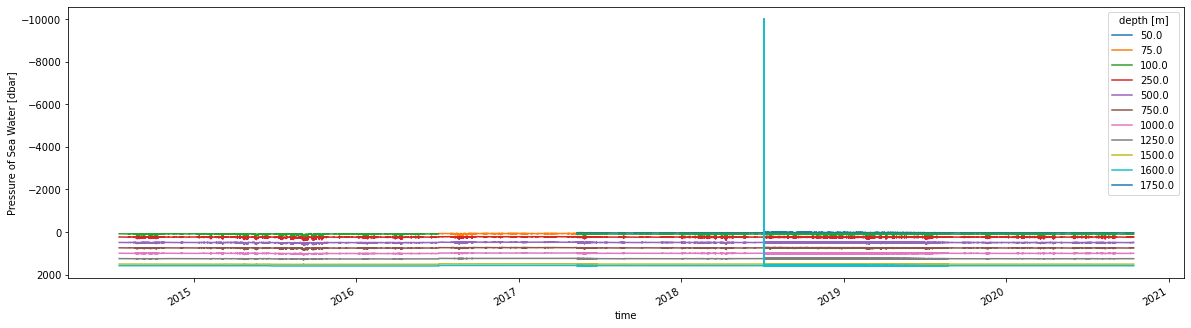

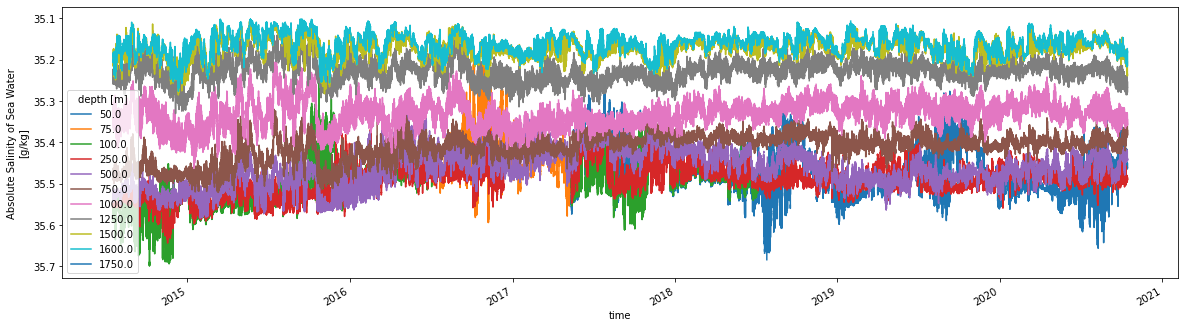

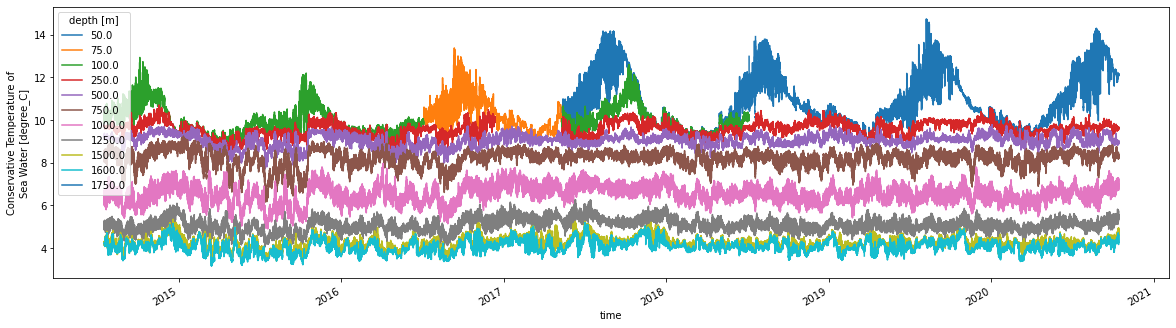

In [8]:
ds.pres.plot.line(x='time',figsize=(20,5), yincrease=False);
ds.sal.plot.line(x='time',figsize=(20,5), yincrease=False);
ds.temp.plot.line(x='time',figsize=(20,5));

# Resample and save to netCDF file
... maybe do resampling for WB later... after combining WB1 & WB2

In [9]:
if moor == 'rteb1':
    ds1D = ds.resample(time = "1D").mean(keep_attrs=True);
    ds1D.to_netcdf(f'data/{moor}_all_merged_1D_new.nc', 
        engine='netcdf4',
        encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})
elif (moor == 'rtwb1') or (moor == 'rtwb2'):
     ds.to_netcdf(f'data/{moor}_all_merged_new.nc', 
        engine='netcdf4',
        encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})

<!-- ###### def despike_moor_data(ds, moor, year): 
    
    if (year != 2017) & (moor != 'rteb1'):
        ds = ds.resample(time = '2h').interpolate("linear")

    #convert to SA from SP
    ds['sal'] = gsw.SA_from_SP(ds.sal, ds.pres, ds.attrs['Longitude'], ds.attrs['Latitude'])
    ds.sal.attrs['long_name'] = "Absolute Salinity of Sea Water" ;
    ds.sal.attrs['units'] = "g/kg" ;

    #convert to pt from t
    #convert to CT from pt
        # -› did both in one go ...
    ds['temp'] = gsw.CT_from_t(ds.sal, ds.temp, ds.pres)
    ds.temp.attrs['standard_name'] = "sea_water_temperature" ;
    ds.temp.attrs['long_name'] = "Conservative Temperature of Sea Water" ;
    ds.temp.attrs['units'] = "degree_C" ;

    #calc median of SA (SA_md) and CT (CT_md)

    SA_md = ds.sal.median('time')
    CT_md = ds.temp.median('time')

    #rm +/-10g/kg 
    ds['sal']= ds.sal.where((((SA_md-10)<ds.sal) & (ds.sal<=(SA_md+10))))
    ds['temp']  = ds.temp.where((((CT_md-10)<ds.temp) & (ds.temp<=(CT_md+10))))


    #loop (n=5): calc md, cut off md +/-1 stand.dev.
    count = 0
    while (count<5):
        SA_std = ds.sal.std('time')
        ds['sal'] = ds.sal.where((((SA_md-SA_std)<ds.sal) & (ds.sal<=(SA_md+SA_std))))

        CT_std = ds.temp.std('time')
        ds['temp'] = ds.temp.where((((CT_md-CT_std)<ds.temp) & (ds.temp<=(CT_md+CT_std))))
        count = count + 1
    
    dummy = ds
    
    return dummy -->